In the following cells, you will witness 2 models created with the goal of making predictions and providing information regarding the League of Legends dataset discussed in the Read Me. 

There are 4 sections:
  1. Library Importing & Creating Data Objects
  2. Gradient Boosting Classifier Model
  3. Deep Net Model
  4. Scoring & Comparison Notes

IN CASE YOU MISSED IT:

You can also check out the first 45 seconds of this video to get a brief look at the game and how complex it is.

https://www.youtube.com/watch?v=mwERJ6qJPuc

Context

League of Legends is a MOBA (multiplayer online battle arena) where 2 teams (blue and red) face off. There are 3 lanes, a jungle, and 5 roles. The goal is to take down the enemy Nexus to win the game.

Content

This dataset contains the first 10min. stats of approx. 10k ranked games (SOLO QUEUE) from a high ELO (DIAMOND I to MASTER). Players have roughly the same level.

Glossary

Minions: NPC that belong to both teams. They give gold when killed by players.

Jungle minions: NPC that belong to NO TEAM. They give gold and buffs when killed by players.

I'll be comparing GradientBoostingClassifer to a Deep Net with 2 hidden layers each with seventy neurons, one neuron in the output layer, and other specifications that I tuned for using GridSearchCV outside this notebook. 

Importing Libraries

In [62]:
# Importing Libraries 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, AlphaDropout
from sklearn.metrics import confusion_matrix, classification_report
from keras.constraints import maxnorm
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc
import datetime, os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

# Uploading data
from google.colab import files
uploaded = files.upload()
%load_ext tensorboard

Saving data_chi3_anova9.csv to data_chi3_anova9 (5).csv
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Uploading and creating Data Objects

In [63]:
df = pd.read_csv(io.BytesIO(uploaded['data_chi3_anova9.csv']))
X = df.iloc[:, 3:]
scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X_df = pd.DataFrame(X_stand, columns=X.columns)
y = df.iloc[:, 2:3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [64]:
X

,bluegolddiff,blueexperiencediff,bluegoldpermin,bluetotalexperience,bteamtotminionsdiff,blaneminions_diff,bluetotalgold
0,643,-8,1721.0,17039,-21,-2,17210
1,-2908,-1173,1471.2,16265,-79,-66,14712
2,-1172,-1033,1611.3,16221,3,-17,16113
3,-1321,-7,1515.7,17954,-24,-34,15157
4,-1004,230,1640.0,18543,-27,-15,16400
...,...,...,...,...,...,...,...
9874,2519,2469,1776.5,18967,19,-18,17765
9875,782,888,1623.8,19255,21,27,16238
9876,-2416,-1877,1590.3,18032,-68,-51,15903
9877,-839,-1085,1445.9,17229,-13,-23,14459


In [65]:
y

,bluewins
0,0
1,0
2,0
3,0
4,0
...,...
9874,1
9875,1
9876,0
9877,0


Creating First model GradientBoostingClassifier which will be abbreviated going forward as GBC.

In [66]:
gbc_tuned = GradientBoostingClassifier(learning_rate=0.01, n_estimators=300,
                                       subsample=0.1, min_samples_leaf=2,
                                       min_samples_split=2, max_depth=4,
                                       max_features=6, min_impurity_decrease=0.1)
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=6, max_leaf_nodes=None,
                           min_impurity_decrease=0.1, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
# we are making predictions here
y_preds_train = gbc_tuned.predict(X_train)
y_preds_test = gbc_tuned.predict(X_test)

The below plot is important because it gives us some insight into the relative "importance" of a single feature's weight on the outcome of a game. This is a distinct advantage because of the "black-box" problem inherent with deep learning. 

Text(0.5, 1.0, 'Variable Importance')

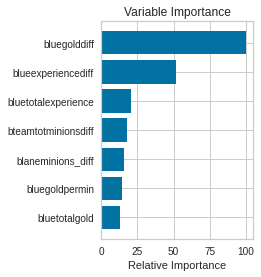

In [68]:
feature_importance = gbc_tuned.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Deep Net Construction noted as MLP going forward

In [69]:
def build_mlp():
  model = keras.Sequential([keras.layers.Dense(70, input_shape=(None, 7), kernel_initializer='glorot_normal',
                                               activation='sigmoid',),
                            keras.layers.Dense(70, activation='selu', kernel_initializer='normal'),
                            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_normal')])
  optomizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.1)
  model.compile(optimizer=optomizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

mlp_model = build_mlp()
mlp_model.fit(X_train, y_train, batch_size=15, epochs=100, verbose=1)

y_mlp = mlp_model.predict(X_test).ravel()

Epoch 1/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5871 - accuracy: 0.6813
Epoch 2/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5565 - accuracy: 0.7123
Epoch 3/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5608 - accuracy: 0.7176
Epoch 4/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5585 - accuracy: 0.7209
Epoch 5/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5559 - accuracy: 0.7205
Epoch 6/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5590 - accuracy: 0.7253
Epoch 7/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5572 - accuracy: 0.7233
Epoch 8/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5583 - accuracy: 0.7191
Epoch 9/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5572 - accuracy: 0.7212
Epoch 10/100
527/527 [==============================] - 1s 1ms/step - loss: 0.5551 - accura

Scoring & Comparison Notes

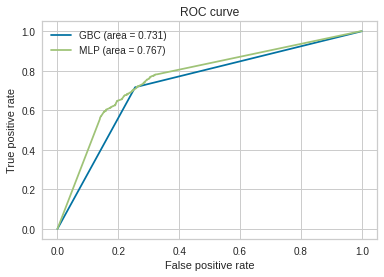

In [70]:
fpr_gbc, tpr_gbc, thresholds_gbc = roc_curve(y_test, y_preds_test)
auc_gbc = auc(fpr_gbc, tpr_gbc)

fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.plot(fpr_gbc, tpr_gbc, label='GBC (area = {:.3f})'.format(auc_gbc))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Quick Note on ROC and AUC from Yellowbirck Documentation:

https://www.scikit-yb.org/en/latest/api/classifier/rocauc.html#

ROC-AUC

Receiver Operating Characteristic (ROC) curves are a measure of a classifier’s predictive quality that compares and visualizes the tradeoff between the models’ sensitivity and specificity. The ROC curve displays the true positive rate on the Y-axis and the false positive rate on the X-axis on both a global average and a per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

This leads to another metric, area under the curve (AUC), a computation of the relationship between false positives and true positives. The higher the AUC, the better the model generally is.

In [71]:
scores = cross_val_score(gbc_tuned, X_train, y_train, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print('GBC AUC : ', auc_gbc)
print()
print('Confusion Matrix GBC')
print(confusion_matrix(y_test, y_preds_test))
print()
print('Classification Matrix GBC')
print(classification_report(y_test, y_preds_test))

Accuracy: 0.72 (+/- 0.00)
GBC AUC :  0.7306696581787634

Confusion Matrix GBC
[[741 254]
 [278 703]]

Classification Matrix GBC
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       995
           1       0.73      0.72      0.73       981

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



In [72]:
y_mlp

array([0.85150737, 0.8444309 , 0.25704753, ..., 0.25704753, 0.25704753,
       0.51815414], dtype=float32)

In [73]:
print('MLP AUC : ', auc_mlp)
print()
print('Confusion Matrix MLP')
print(confusion_matrix(y_test, y_mlp.round(decimals=0, out=None)))
print()
print('Classification Matrix MLP')
print(classification_report(y_test, y_mlp.round(decimals=0, out=None)))

MLP AUC :  0.7668654178128153

Confusion Matrix MLP
[[702 293]
 [240 741]]

Classification Matrix MLP
              precision    recall  f1-score   support

           0       0.75      0.71      0.72       995
           1       0.72      0.76      0.74       981

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976



Before comparing performance let's discuss the overall pros and cons of the models used. This is by no means intended to be an exhaustive comparison between these two methods, but general things to keep in mind when considering model choice. 

The GBC has the advantage of being relatively less "complex" than the MLP. Complexity refers to not only the computational complexity but also the parameters needed to be tuned to reach similar accuracy. Also as eluded to earlier, the GBC model is not a "black-box" model, meaning we can extract things like feature importance and overall get a more transparent look into the models' operations and how it reached a certain conclusion or prediction.

The MLP actually has a higher AUC and has more precision regarding games where the blue team wins or the true value is 1. 

The MLP success is not as "stable" or predictable as the GBC due to the lack of reproducibility of Deep Nets in general.

Overall I would say that the MLP shows more promise than the GBC regarding exploratory work. (There were some gaps in my tuning that may be holding back the MLP's predictive performance) I say this because of the AUC score being closer to one means that we find higher separability between winning and losing games when using the MLP model.

The MLP model is a better predictive model, but may sometimes fall behind GBC choice due to its relative lack of reproducibility of Deep Nets in general. 

Thanks for Checking out the notebook!